In [ ]:
# This notebook will involve splitting the dataset n different times and running it across (70_10_20) 3 rounds or something due to compute

What is needed to achieve a multiple train-val-test split? Run it across 5 runs maybe and see how it performs, my initial hypothesis was that the variance in the results was as a result of random initialization in the model weights, however, it seems like the data splits could play a factor into this. I propose running multiple train, val and test splits and testing the models to see how it performs across different data distributions maybe?


Define the classification task to be used
1. Split the dataset into train, val and test splits using 70-10-20 rule with stratified sampling depending on whether the task is informative or the other task
2. Do any data transformations that are required at this step
3. Depending on the task - whether binary or multilabel classification task - encode the labels to targets i.e. number format
4. Get the context required for all the data points - shouldn't take a while but would probably take a while on the
4. Tokenize the sentences to get input ids, attention masks and numerical feats for the other task

# Init project and add library dependencies


In [ ]:
# Add imports
# Load the ushahidi dataset and print out first rows
# Perform text preprocessing - similar to what i did for the baseline classifiers - create clean text
# Train first XLM Roberta model and see how it perfroms
# Might try training all models this weekend, and then the next goal could be to see how to use the
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
import textwrap
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',1000)
from itertools import cycle
import random
import torch
import csv
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import TensorDataset
from transformers import BertConfig


# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80, initial_indent='    ',
                               subsequent_indent='    ')

nltk.download('stopwords')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

ModuleNotFoundError: ignored

# Load the data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load data
model_data = pd.read_csv('/content/drive/My Drive/thesis/labelled_election_reports_with_sent.csv', encoding='utf-8')
train_data = pd.read_csv('/content/drive/My Drive/thesis/train_election_reports.csv', encoding='utf-8')
val_data = pd.read_csv('/content/drive/My Drive/thesis/val_election_reports.csv', encoding='utf-8')
test_data = pd.read_csv('/content/drive/My Drive/thesis/test_election_reports.csv', encoding='utf-8')

In [ ]:
print(model_data.shape)

(14181, 17)


In [ ]:
# Explore the list of columns in the dataset
print(model_data.columns)

Index(['text', 'clean_text', 'normalized_text', 'merged_label', 'label',
       'status', 'Election Date', 'date', 'informative_label',
       'election_distance', 'election_distance_abs', 'hour', 'hour_sin',
       'hour_cos', 'negative', 'neutral', 'positive'],
      dtype='object')


In [ ]:
# Create sentiment scores for each election report

In [ ]:
# Check whether GPU is detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00


In [ ]:
# Training models with just text data and not fusing additional features

In [ ]:
model_data['informative_label'].unique()

array(['Non-Informative', 'Informative'], dtype=object)

In [ ]:
# Function that takes in the data and performs a random split
def split_model_data(model_data, classification_task = 'Binary'):

  stratify_label = 'informative_label'

  # model_data = model_data[model_data['status'] == 'published']

  if classification_task == 'Multi-Class':
    stratify_label = 'merged_label'
    model_data = model_data[model_data['informative_label'] == 'Informative']

  # Perform train-test split (70% train, 30% test)
  train_data, test_data = train_test_split(
      model_data,  # Assuming 'text' column contains the input data
      test_size=0.2,
      stratify=model_data[stratify_label]  # Perform stratified sampling based on labels
  )

  # # Perform further split on the test set to create validation set (10% validation, 20% test)
  # test_data, val_data = train_test_split(
  #     test_data,
  #     test_size=0.33,  # 10% of the test set (0.33 * 0.3 = 0.099 ≈ 10%)
  #     stratify=test_data[stratify_label]  # Perform stratified sampling based on labels
  # )

  # Print the sizes of each split
  print("Train set size:", len(train_data))
  # print("Validation set size:", len(val_data))
  print("Test set size:", len(test_data))

  return train_data, test_data

In [ ]:
def encode_labels(train_data, test_data, classification_task = 'Binary'):
  target_column = 'informative_label'

  if classification_task == 'Multi-Class':
    target_column = 'merged_label'

  label_encoder = LabelEncoder()
  label_encoder.fit(train_data[target_column])
  train_data["target"] = label_encoder.transform(train_data[target_column])
  # val_data["target"] = label_encoder.transform(val_data[target_column])
  test_data["target"] = label_encoder.transform(test_data[target_column])

  mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
  return train_data, test_data, mapping

In [ ]:
def tokenize(tokenizer, max_len, sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  # Uncomment to debug the code
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [ ]:
import torch
from transformers import AutoTokenizer
from transformers import XLMRobertaForSequenceClassification
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup
import os

In [ ]:
# Connect to the GPU.
device = torch.device('cuda')
# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

  GPU: Tesla T4


In [ ]:
def init_tokenizer(model_name= 'xlm-roberta-base'):
  # Code to initialize tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  return tokenizer

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
def train_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler):
  training_stats = []
  total_t0 = time.time()
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update.
        # if (step % update_interval) == 0 and not step == 0:
        #     # Calculate elapsed time in minutes.
        #     elapsed = format_time(time.time() - t0)
        #     # Report progress.
        #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

        logits = result.logits
        # loss = result.loss

        criterion = torch.nn.CrossEntropyLoss(class_weights)
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

In [ ]:
def test_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
def train_test_multiple_splits(no_of_splits, classification_task, model_data, model_name, epochs, batch_size):
  results = {}
  mapping = {}
  for idx in range(0, no_of_splits):
    print(f"Currently running split {idx + 1}")

    # Get the train, test and validation data splits
    train_data, test_data = split_model_data(model_data, classification_task)

    # Encode the target variables
    train_data, test_data, mapping = encode_labels(train_data, test_data, classification_task)
    mapping = mapping

    # Get train sentences and targets
    train_sentences, train_targets = train_data.normalized_text.values, train_data.target.values
    # val_sentences, val_targets = val_data.normalized_text.values, val_data.target.values
    test_sentences, test_targets = test_data.normalized_text.values, test_data.target.values

    # Get class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
    class_weights = torch.tensor(class_weights,dtype=torch.float)

    # Tokenize sentences
    tokenizer = init_tokenizer()
    train_input_ids, train_attention_masks, train_labels = tokenize(tokenizer, 128, train_sentences, train_targets)
    # val_input_ids, val_attention_masks, val_labels = tokenize(tokenizer, 128, val_sentences, val_targets)
    test_input_ids, test_attention_masks, test_labels = tokenize(tokenizer, 128, test_sentences, test_targets)

    # Create datasets
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    # val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

    # Create dataloaders
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

    # # For validation the order doesn't matter, so we'll just read them sequentially.
    # val_dataloader = DataLoader(
    #             val_dataset, # The validation samples.
    #             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    #             batch_size = batch_size # Evaluate with this batch size.
    #         )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    # Set dropout rate
    dropout_rate = 0.3

    # Init model
    model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(train_targets)))
    model.config.update({'hidden_dropout_prob': dropout_rate})

    # Load model to the GPU
    print('Loading model to GPU...')
    # Copy the initial model weights to the GPU.
    desc = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    print(f"Training Current run: {idx+1}")
    train_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler)
    print(f"Testing Current run: {idx+1}")
    # Test model on test set
    predictions, true_labels = test_model(model, test_dataloader)
    results[f"Run {idx+1}"] = (predictions, true_labels)

    # Save instance of the model
    save_directory = f'/content/drive/My Drive/thesis/models/new/{classification_task}/Run{idx+1}'
    os.makedirs(save_directory, exist_ok=True)
    model.save_pretrained(save_directory)

    # Save data splits
    data_directory = f'/content/drive/My Drive/thesis/multiple_runs/new/{classification_task}/Run{idx+1}'
    os.makedirs(data_directory, exist_ok=True)

    train_data.to_csv(f"{data_directory}/train_data.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)
    # val_data.to_csv(f"{data_directory}/val_data.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)
    test_data.to_csv(f"{data_directory}/test_data.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)

  return results, mapping

In [ ]:
dataset_size = len(train_data)

In [ ]:
#Test effect of data sizes
fold_sizes = [100, 500, 2000, 4000, 6000, 9000]
percentage_folds = [fold/dataset_size for fold in fold_sizes]

In [ ]:
informative_train_data = train_data[train_data['informative_label'] == 'Informative']
informative_test_data = test_data[test_data['informative_label'] == 'Informative']

In [ ]:
#Uncomment for information type classification task
# X_train = informative_train_data['normalized_text']
# y_train = informative_train_data['merged_label']
# test_sentences = informative_test_data['normalized_text']
# y_test = informative_test_data['merged_label']


X_train = train_data['normalized_text']
y_train = train_data['merged_label']
test_sentences = test_data['normalized_text']
y_test = test_data['merged_label']

In [ ]:
f1_scores = []
precisions = []
recalls = []

for fold_size in percentage_folds:
  # Split the data into the current fold
  train_sentences, _, y_train_fold, _= train_test_split(X_train, y_train, train_size=fold_size, stratify=y_train)

  # Label encode the targets
  target_column = 'informative_label'
  label_encoder = LabelEncoder()
  label_encoder.fit(y_train_fold)
  train_targets = label_encoder.transform(y_train_fold)
  test_targets = label_encoder.transform(y_test)

  tokenizer = init_tokenizer()
  train_input_ids, train_attention_masks, train_labels = tokenize(tokenizer, 128, train_sentences, train_targets)
  test_input_ids, test_attention_masks, test_labels = tokenize(tokenizer, 128, test_sentences, test_targets)

  # Create datasets
  train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
  test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

  # Create dataloaders
  train_dataloader = DataLoader(
          train_dataset,  # The training samples.
          sampler = RandomSampler(train_dataset), # Select batches randomly
          batch_size = 32 # Trains with this batch size.
      )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  test_dataloader = DataLoader(
              test_dataset, # The validation samples.
              sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
              batch_size = 32 # Evaluate with this batch size.
          )

  class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
  class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

  # Set dropout rate
  dropout_rate = 0.3

  # Init model
  model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=len(np.unique(train_targets)))
  model.config.update({'hidden_dropout_prob': dropout_rate, 'attention_probs_dropout_prob': dropout_rate})

  # Load model to the GPU
  print('Loading model to GPU...')
  # Copy the initial model weights to the GPU.
  desc = model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate
                eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
              )

  # Total number of training steps is [number of batches] x [number of epochs].
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * 3

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)
  # Measure the total training time for the whole run.
  train_model(model, train_dataloader, 3, class_weights, optimizer, scheduler)
  # Test model on test set
  predictions, true_labels = test_model(model, test_dataloader)

  flat_predictions = np.concatenate(predictions, axis=0)
  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)
  # Calculate the classification report metrics
  report = classification_report(flat_true_labels, flat_predictions, output_dict=True)
  # Extract F1-score, precision, and recall
  f1_score = report['macro avg']['f1-score']
  precision = report['macro avg']['precision']
  recall = report['macro avg']['recall']

  # Append the metrics to the lists
  f1_scores.append(f1_score)
  precisions.append(precision)
  recalls.append(recall)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.76
  Training epoch took: 0:00:02

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.80
  Training epoch took: 0:00:01

======== Epoch 3 / 3 ========
Training...

  Average training loss: 1.82
  Training epoch took: 0:00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Truncation was not explicitly activated but `max_length` is prov

Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.80
  Training epoch took: 0:00:04

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.79
  Training epoch took: 0:00:04

======== Epoch 3 / 3 ========
Training...

  Average training loss: 1.79
  Training epoch took: 0:00:04


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Truncation was not explicitly activated but `max_length` is prov

Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.79
  Training epoch took: 0:00:14

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.74
  Training epoch took: 0:00:14

======== Epoch 3 / 3 ========
Training...

  Average training loss: 1.63
  Training epoch took: 0:00:14


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint 

Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.66
  Training epoch took: 0:00:28

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.24
  Training epoch took: 0:00:28

======== Epoch 3 / 3 ========
Training...

  Average training loss: 1.03
  Training epoch took: 0:00:28


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint 

Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.64
  Training epoch took: 0:00:43

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.16
  Training epoch took: 0:00:43

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.94
  Training epoch took: 0:00:43


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint 

Loading model to GPU...

======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.50
  Training epoch took: 0:01:04

======== Epoch 2 / 3 ========
Training...

  Average training loss: 1.06
  Training epoch took: 0:01:04

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.87
  Training epoch took: 0:01:04


In [ ]:
f1_scores

[0.06630017872768247,
 0.18082006965208378,
 0.3499798223394384,
 0.4669372689042845,
 0.4993606739004226,
 0.5165048904357423]

In [ ]:
fold_sizes

[100, 500, 2000, 4000, 6000, 9000]

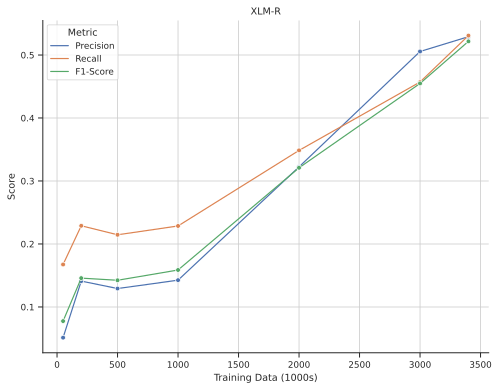

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have lists of precision, recall, and f1_scores
# containing the metrics for each iteration or fold

# Create a list of iteration or fold numbers
iterations = range(1, len(precisions) + 1)

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Iteration': fold_sizes,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

# Melt the DataFrame to transform the metrics into a single column
melted_df = pd.melt(metrics_df, id_vars=['Iteration'], var_name='Metric', value_name='Score')
sns.set(style='ticks', context='paper')
# Plot the graph using Seaborn's lineplot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_df, x='Iteration', y='Score', hue='Metric', marker='o')

# Set the y-axis limits to be between 0 and 1
# plt.ylim(0.4, 0.9)

# Remove top and right spines
sns.despine()

# Add gridlines
plt.grid(True)

# Set labels and title
plt.xlabel('Training Data (1000s)')
plt.ylabel('Score')
plt.title('XLM-R')
plt.savefig('svm_data_sizes.svg')

# Show the plot
plt.show()

In [ ]:
melted_df.to_csv('bert_iterations.csv')

In [ ]:
results, mapping = train_test_multiple_splits(no_of_splits = 1,
                                     classification_task = 'Multi-Class',
                                     model_data = model_data,
                                     model_name = 'xlm-roberta-base',
                                     epochs = 4,
                                     batch_size = 32)

Currently running split 1
Train set size: 3901
Test set size: 976


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint 

Loading model to GPU...
Training Current run: 1

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.31
  Training epoch took: 0:00:28

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.89
  Training epoch took: 0:00:28

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.73
  Training epoch took: 0:00:28

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.63
  Training epoch took: 0:00:28
Testing Current run: 1


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
#Util function to plot confusion matrix with percentages
def plot_cm_with_percentages(labels, predictions, class_labels, name=""):
    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Calculate row-wise sums to get the total counts for each true label
    row_sums = cm.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages = np.round((cm / row_sums) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = '.2f': show numbers as floats with 2 decimal places
    ax = sns.heatmap(cm_percentages, annot=True, fmt='.2f', cmap='gist_gray')

    # Format the annotations as percentages
    for _, value in enumerate(ax.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")

    # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.set_xticklabels(class_labels)

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", fontsize=12, labelpad=20)
    ax.set_yticklabels(class_labels)

    # Set plot title
    # ax.set_title("Confusion Matrix", fontsize=12, pad=20)

    from datetime import datetime

    # Generate a timestamp for the file name
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # Save the figure as an SVG file with timestamp in the file name
    # plt.savefig(name, format='svg')

    plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

def average_classification_report(predictions_dict, target_names, classification_task = 'Binary'):
    num_runs = len(predictions_dict)
    labels = list(target_names)  # Get unique labels

    # Initialize variables to accumulate metrics
    avg_precision = {label: 0.0 for label in labels}
    avg_recall = {label: 0.0 for label in labels}
    avg_f1_score = {label: 0.0 for label in labels}
    avg_support = {label: 0 for label in labels}
    avg_accuracy = 0.0
    avg_auc = 0.0

    # Initialize variables for macro average metrics
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1_score = 0.0

    # Variables to track best model
    best_model_f1_score = float('-inf')
    best_model_predictions = None
    best_model_true_labels = None

    all_scores = []
    accuracies = []
    auc_scores = []

    # Calculate metrics for each run and accumulate
    for model_id, (predictions, true_labels) in predictions_dict.items():
        # Combine the results across all batches.
        flat_predictions = np.concatenate(predictions, axis=0)

        # For each sample, pick the label (0 or 1) with the higher score.
        flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
        flat_true_labels = np.concatenate(true_labels, axis=0)

        # Calculate accuracy
        accuracy = accuracy_score(flat_true_labels, flat_predictions)
        avg_accuracy += accuracy
        accuracies.append(accuracy)

        # Calculate AUC score for the binary classifiers if classification task is binary
        if classification_task == 'Binary':
          ft_predictions_tensor = torch.tensor(np.concatenate(predictions, axis=0))
          predicted_probabilities = torch.softmax(ft_predictions_tensor, dim=1)
          auc_score = roc_auc_score(flat_true_labels, predicted_probabilities[:, 1])
          auc_scores.append(auc_score)
          avg_auc += auc_score

        report = classification_report(flat_true_labels, flat_predictions, target_names=target_names, output_dict=True)
        all_scores.append(report['macro avg']['f1-score'])

        # Accumulate precision, recall, f1-score, and support
        for label in labels:
            avg_precision[label] += report[label]['precision']
            avg_recall[label] += report[label]['recall']
            avg_f1_score[label] += report[label]['f1-score']
            avg_support[label] += report[label]['support']

        # Accumulate macro average metrics
        macro_precision += report['macro avg']['precision']
        macro_recall += report['macro avg']['recall']
        macro_f1_score += report['macro avg']['f1-score']

        # Check if current model has a higher macro average F1 score
        if report['macro avg']['f1-score'] > best_model_f1_score:
            best_model_f1_score = report['macro avg']['f1-score']
            best_model_predictions = flat_predictions
            best_model_true_labels = flat_true_labels

    # Average metrics across runs
    avg_precision = {label: avg_precision[label] / num_runs for label in labels}
    avg_recall = {label: avg_recall[label] / num_runs for label in labels}
    avg_f1_score = {label: avg_f1_score[label] / num_runs for label in labels}
    avg_support = {label: avg_support[label] / num_runs for label in labels}
    avg_accuracy /= num_runs
    avg_auc /= num_runs

    # Average macro average metrics across runs
    macro_precision /= num_runs
    macro_recall /= num_runs
    macro_f1_score /= num_runs

    # Create average classification report
    avg_report = classification_report(labels, labels, labels=labels, output_dict=True)
    for label in labels:
        avg_report[label]['precision'] = avg_precision[label]
        avg_report[label]['recall'] = avg_recall[label]
        avg_report[label]['f1-score'] = avg_f1_score[label]
        avg_report[label]['support'] = avg_support[label]

    # Add macro average metrics to the classification report
    avg_report['macro avg'] = {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1-score': macro_f1_score,
        'support': np.sum(list(avg_support.values()))
    }

    # Calculate weighted average metrics
    weighted_precision = np.average(list(avg_precision.values()), weights=list(avg_support.values()))
    weighted_recall = np.average(list(avg_recall.values()), weights=list(avg_support.values()))
    weighted_f1_score = np.average(list(avg_f1_score.values()), weights=list(avg_support.values()))

    # Add weighted average metrics to the classification report
    avg_report['weighted avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1_score,
        'support': np.sum(list(avg_support.values()))
    }


    return (best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy, avg_auc

In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy,avg_auc_score = average_classification_report(results, target_names = mapping.keys(), classification_task='Multi-Class')

In [ ]:
avg_auc_score

0.0

In [ ]:
mapping

{'Counting and Results': 0,
 'Political Rallies': 1,
 'Positive Events': 2,
 'Security Issues': 3,
 'Voting Issues': 4}

In [ ]:
print(macro_f1_score)

0.7055477450336711


In [ ]:
np.std(all_scores)

0.0

In [ ]:
print(avg_accuracy)

0.7370218579234974


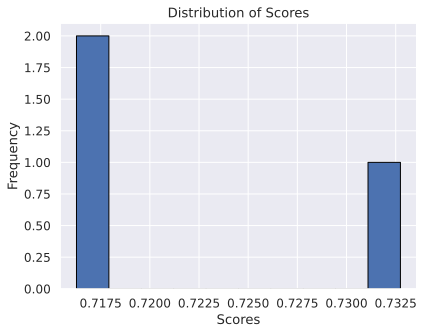

In [ ]:
# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

In [ ]:
informative_results_df = pd.DataFrame.from_dict(avg_report)

In [ ]:
informative_results_df

,Counting and Results,Political Rallies,Positive Events,Security Issues,Voting Issues,accuracy,macro avg,weighted avg
precision,0.766952,0.702423,0.769069,0.690643,0.704129,1.0,0.726643,0.738325
recall,0.751220,0.713675,0.790087,0.639344,0.704678,1.0,0.719801,0.737022
f1-score,0.758348,0.707825,0.778535,0.663705,0.702933,1.0,0.722269,0.736629
support,205.000000,78.000000,343.000000,122.000000,228.000000,1.0,976.000000,976.000000


In [ ]:
informative_results_df.to_csv('/content/drive/My Drive/thesis/informative_averaged_results_multiple_data_splits.csv')

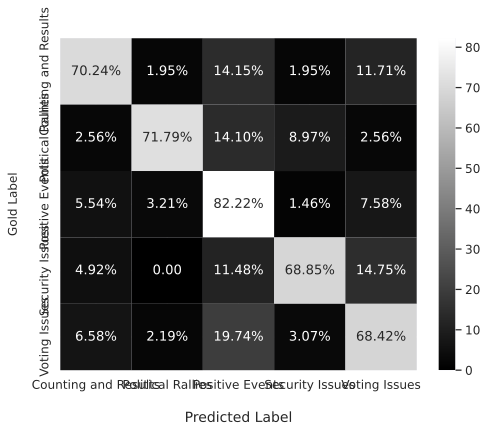

In [ ]:
# Showing the results of the best performing model
plot_cm_with_percentages(best_model_true_labels, best_model_predictions, mapping, name="information_types_best.svg")

In [ ]:
all_scores

[0.7327400531824354, 0.717796675648721, 0.7162702507926904]

In [ ]:
# Next pitstop - include code for BERT with fused features

In [ ]:
class XLMRobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.combined_feat_dim, config.combined_feat_dim)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(config.combined_feat_dim, config.num_labels)

    def forward(self, features, **kwargs):
        # x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

NameError: ignored

In [ ]:
from torch import nn
from transformers import XLMRobertaForSequenceClassification
from torch.nn import CrossEntropyLoss, MSELoss

class BertConcatFeatures(XLMRobertaForSequenceClassification):

  def __init__(self, config):
    #BERT SETUP - calls the constructor for BertForSequenceClassification to
    # do the initial configuration - going to do all the BERT related setup.
    # The resulting BERT model is stored in `self.bert`.
    super().__init__(config)
    # Feature combination
    # Store the number of labels, which tells us whether this is a classification
    # or a regression task
    self.num_labels = config.num_labels
    # Calculate the combined vector length - CLS embedding + additional features
    # combined_feat_dim = config.text_feat_dim + config.context_feat_dim + config.numerical_feat_dim

    combined_feat_dim = config.text_feat_dim  + config.numerical_feat_dim

    # # Create a batch normalzier for the numerical features
    self.num_bn = nn.BatchNorm1d(config.numerical_feat_dim)

    # MLP Setup - specify the number of layers and neurons in each layer
    # Dimensions of each MLP layer
    dims = []
    # Starting with the combined feature vector length...
    dim = combined_feat_dim
    while True:

      #Divide by 4 and truncate to an interger
      dim = dim // 4
      # If the resulting later size would be smaller than the number of outpurs,
      # then we're done
      if dim <= self.num_labels:
        break
      #Otherise, store this as the next layer size
      dims.append(int(dim))

    # Print out the resulting the MLP
    print('MLP Layer sizes:')
    print(' Input:', combined_feat_dim)
    print(' Output:', self.num_labels)
    # Construct the MLP, specifying the number of inputs, outputs and the layer sizes

    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    classifier_dropout = (
      config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
    )
    self.dropout = nn.Dropout(classifier_dropout)
    self.output_proj = nn.Linear(combined_feat_dim, config.num_labels)

  def forward(
      self,
      input_ids=None,
      attention_mask=None,
      token_type_ids=None,
      position_ids=None,
      head_mask=None,
      inputs_embeds=None,
      labels = None,
      class_weights=None,
      output_attentions=None,
      output_hidden_states=None,
      # context_input_ids = None,
      # context_attention_mask = None,
      # context_token_type_ids = None,
      # context_position_ids = None,
      # context_head_mask = None,
      # context_inputs_embeds = None,
      # context_output_attentions = None,
      # context_output_hidden_states = None,
      numerical_feats=None,
      concat_context=False,
  ):

    # print("We are here --> does it even get here?")

    #Send text throught the BERT model
    outputs = self.roberta(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states
    )

    # if concat_context == True:
    #   # Send context through BERT model as well
    #   context_outputs = self.roberta(
    #       context_input_ids,
    #       attention_mask=context_attention_mask,
    #       token_type_ids=context_token_type_ids,
    #       position_ids=context_position_ids,
    #       head_mask=context_head_mask,
    #       inputs_embeds=context_inputs_embeds,
    #       output_attentions=context_output_attentions,
    #       output_hidden_states=context_output_hidden_states
    #   )

    #   context_output = context_outputs[0]
    #   context_cls = context_output[:, 0, :]
    #   context_cls = self.dropout(context_cls)

    # print("Are wee even here?")
    # Take the CLS embedding
    sequence_output = outputs[0]
    cls = sequence_output[:, 0, :]
    cls = self.dropout(cls)
    cls = self.dense(cls)
    cls = torch.tanh(cls)
    cls = self.dropout(cls)
    # cls = self.dropout(cls)

    # print("We are here --> debugging")
    #Concatenate features
    # Apply batch normalization to the numerical features
    numerical_feats = numerical_feats.float()

    # if concat_context == True:
    #   combined_feats = torch.cat((cls, context_cls, numerical_feats), dim=1)

    # print("Is the problem coming from the combination?")
    #Simply concatenate everything into one vector
    combined_feats = torch.cat((cls, numerical_feats), dim=1)

    # Output classifier/regression
    logits = self.output_proj(combined_feats)

    if type(logits) is tuple:
      logits, classifier_layer_outputs = logits[0], logits[1]
    else:
      classifier_layer_outputs = [cls, logits]

    # Calculate loss
    if labels is not None:
      # Regression
      if self.num_labels == 1:
        loss_fct = MSELoss()
        labels = labels.float()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        # print("Is the problem coming from cross entropy loss calculation?")
        loss_fct = CrossEntropyLoss(weight=class_weights, reduction='mean')
        # loss_fct = CrossEntropyLoss()
        labels = labels.long()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    else:
      loss = None

    # print("I'd laugh if we actually get here")
    results = {
        'loss': loss,
        'logits': logits,
        'classifier_layer_outputs': classifier_layer_outputs
    }

    return results

In [ ]:
def train_custom_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler):
  training_stats = []
  total_t0 = time.time()
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_numer_feats = batch[1].double().to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        # b_context_input_ids = batch[4].to(device)
        # b_context_input_mask = batch[5].to(device)

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels = b_labels,
                       numerical_feats = b_numer_feats,
                       class_weights = class_weights)
                      #  context_input_ids = b_context_input_ids,
                      #  context_attention_mask = b_context_input_mask)

        loss = result['loss']
        logits = result['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

In [ ]:
def test_custom_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_numerical_feats, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      numerical_feats = b_numerical_feats)

    logits = result['logits']

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
sep = ' [SEP] '
def get_context(df, support_df, context_size=3):
  '''
  This function takes two dataframes, the first, df - is the dataframe to calculate
  context embeddings for while the support df is the reference to use to check the
  context, in the case of train data, both the df and support df will be the same,
  this is to ensure that no test data leaks into the training context embeddings. For
  test embeddings, the support df will be the whole dataset
  '''
  contexts = []
  sorted_dates = df.sort_values('date')['date']
  dates_list = sorted_dates.to_list()
  # Iterate over rows using iterrows()
  for index, row in df.iterrows():
    current_date = row['date']
    current_date_index = dates_list.index(current_date)
    previous_posts = dates_list[max(0, current_date_index - context_size) : current_date_index]
    context = ""
    for idx, dt in enumerate(previous_posts):
      record = support_df[support_df['date'] == dt].iloc[0]
      # Only consider context fromt the same election
      if record['Election Date'] == row['Election Date']:
        context += (record.normalized_text + sep)
    contexts.append(context)
  return contexts

In [ ]:
sep = ' [SEP] '
def combine_features(df):
  sentences = []
  labels = []
  df['context'] = df['context'].fillna('')

  # For each of the samples...
  for index, row in df.iterrows():
      # Piece it together...
      context = row["context"]
      text = row["normalized_text"]
      combined_text = context + text
      sentences.append(combined_text)
      labels.append(row["target"])
  print('  DONE.')
  print('Dataset contains {:,} samples.'.format(len(sentences)))
  return sentences, labels

In [ ]:
def tokenize_with_numerical(tokenizer, sentences, labels, numerical_feats):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 300,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation_strategy='only_first',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  numerical_feats = torch.tensor(numerical_feats)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # # Print sentence 0, now as a list of IDs.
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, numerical_feats, attention_masks, labels

In [ ]:
numerical_feats = ['election_distance_transformed', 'hour_cos', 'hour_sin','negative','neutral','positive']

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
def transform_election_distance(train_data, test_data):
  # Create an instance of QuantileTransformer
  transformer = QuantileTransformer(random_state=0)
  # Reshape the input data to have the appropriate dimensions
  train_election_distance_reshaped = train_data['election_distance'].values.reshape(-1, 1)
  transformer.fit(train_election_distance_reshaped)

  train_data['election_distance_transformed'] = transformer.transform(train_election_distance_reshaped)

  test_election_distance_reshaped = test_data['election_distance_abs'].values.reshape(-1, 1)
  test_data['election_distance_transformed'] = transformer.transform(test_election_distance_reshaped)

  return train_data, test_data

In [ ]:
def train_test_multiple_splits_fused(no_of_splits, classification_task, model_data, model_name, epochs, batch_size):
  results = {}
  mapping = {}
  for i in range(0, no_of_splits):
    print(f"Currently running split {i + 1}")

    # Get the train, test and validation data splits
    train_data, test_data = split_model_data(model_data, classification_task)

    # Transform election distance
    train_data, test_data = transform_election_distance(train_data, test_data)

    # Encode the target variables
    train_data, test_data, mapping = encode_labels(train_data, test_data, classification_task)
    mapping = mapping

    train_contexts = get_context(train_data, train_data)
    test_contexts = get_context(test_data, model_data)

    train_data["context"] = train_contexts
    test_data["context"] = test_contexts

    # Get train sentences and targets
    train_sentences, train_targets = combine_features(train_data)
    # val_sentences, val_targets = val_data.normalized_text.values, val_data.target.values
    test_sentences, test_targets = combine_features(test_data)

    # Get class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
    class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

    # Tokenize sentences
    tokenizer = init_tokenizer()
    train_input_ids, train_numerical_feats, train_attention_masks, train_labels = tokenize_with_numerical(tokenizer,
                                                                                                          train_sentences,
                                                                                                          train_targets,
                                                                                                          train_data[numerical_feats].values)
    test_input_ids, test_numerical_feats, test_attention_masks, test_labels = tokenize_with_numerical(tokenizer,
                                                                                                      test_sentences,
                                                                                                      test_targets,
                                                                                                      test_data[numerical_feats].values)

    # Create datasets
    train_dataset = TensorDataset(train_input_ids, train_numerical_feats, train_attention_masks, train_labels)
    test_dataset = TensorDataset(test_input_ids, test_numerical_feats, test_attention_masks, test_labels)

    # Create dataloaders
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


    # For validation the order doesn't matter, so we'll just read them sequentially.
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    # Init config
    config = BertConfig.from_pretrained('xlm-roberta-base', num_labels=len(np.unique(train_targets)))
    config.numerical_feat_dim = 6
    config.text_feat_dim = config.hidden_size
    config.combined_feat_dim = config.hidden_size + config.numerical_feat_dim
    # config.context_feat_dim = config.hidden_size

    # Initialize model and load it to device every single time
    model = BertConcatFeatures.from_pretrained(
        'xlm-roberta-base',
        config = config
        )

    # Move model to device
    desc = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    print(f"Training Current run: {i+1}")
    train_custom_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler)
    print(f"Testing Current run: {i+1}")
    # Test model on test set
    predictions, true_labels = test_custom_model(model, test_dataloader)
    results[f"Run {i+1}"] = (predictions, true_labels)

    # # Save instance of the model
    # save_directory = f'/content/drive/My Drive/thesis/models/fused/{classification_task}/Run{i+1}'
    # os.makedirs(save_directory, exist_ok=True)
    # model.save_pretrained(save_directory)

    # # Save data splits
    # data_directory = f'/content/drive/My Drive/thesis/multiple_runs/fused/{classification_task}/Run{i+1}'
    # os.makedirs(data_directory, exist_ok=True)

    # train_data.to_csv(f"{data_directory}/train_data.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)
    # test_data.to_csv(f"{data_directory}/test_data.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)

  return results, mapping

In [ ]:
results, mapping = train_test_multiple_splits_fused(no_of_splits = 1,
                                     classification_task = 'Multi-Class',
                                     model_data = model_data,
                                     model_name = 'xlm-roberta-base',
                                     epochs = 4,
                                     batch_size = 16)

Currently running split 1
Train set size: 3901
Test set size: 976
  DONE.
Dataset contains 3,901 samples.
  DONE.
Dataset contains 976 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning

MLP Layer sizes:
 Input: 774
 Output: 5


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['num_bn.bias', 'dense.weight', 'dense.bias', 'classifier.dense.bias', 'num_bn.running_var', 'output_proj.weight

Training Current run: 1

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.25
  Training epoch took: 0:01:08

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.82
  Training epoch took: 0:01:09

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:01:09

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.46
  Training epoch took: 0:01:09
Testing Current run: 1


In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy,avg_auc = average_classification_report(results, target_names = mapping.keys(), classification_task='Multi-Class')

In [ ]:
avg_auc

0.0

In [ ]:
print(macro_f1_score)

0.6658749245672698


In [ ]:
print(avg_accuracy)

0.6700819672131147


In [ ]:
pd.DataFrame(avg_report)

,Counting and Results,Political Rallies,Positive Events,Security Issues,Voting Issues,accuracy,macro avg,weighted avg
precision,0.751835,0.744336,0.744223,0.682706,0.702358,1.0,0.725092,0.728361
recall,0.767480,0.696581,0.784257,0.653005,0.659357,1.0,0.712136,0.728142
f1-score,0.758954,0.718868,0.763103,0.666515,0.680169,1.0,0.717522,0.727249
support,205.000000,78.000000,343.000000,122.000000,228.000000,1.0,976.000000,976.000000


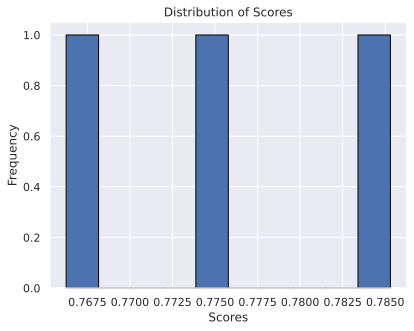

In [ ]:
# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

FileNotFoundError: ignored

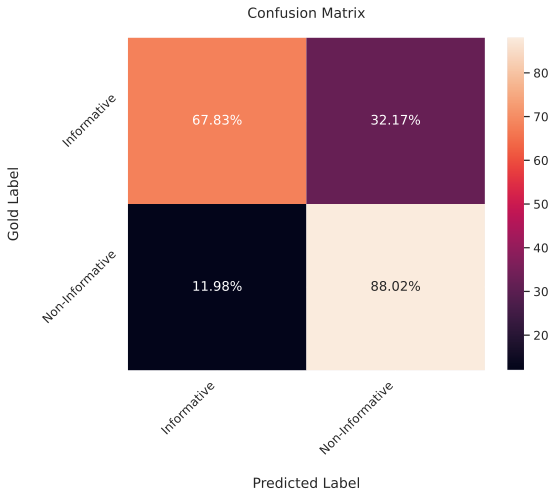

In [ ]:
# Showing the results of the best performing model
plot_cm_with_percentages(best_model_true_labels, best_model_predictions, mapping)

In [ ]:
results, mapping = train_test_multiple_splits_fused(no_of_splits = 3,
                                     classification_task = 'Multi-Class',
                                     model_data = model_data,
                                     model_name = 'xlm-roberta-base',
                                     epochs = 4,
                                     batch_size = 32)

Currently running split 1
Train set size: 3901
Test set size: 976
  DONE.
Dataset contains 3,901 samples.
  DONE.
Dataset contains 976 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning

MLP Layer sizes:
 Input: 774
 Output: 5
Training Current run: 1

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.38
  Training epoch took: 0:00:48

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.95
  Training epoch took: 0:00:48

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.78
  Training epoch took: 0:00:48

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.68
  Training epoch took: 0:00:48
Testing Current run: 1
Currently running split 2
Train set size: 3901
Test set size: 976
  DONE.
Dataset contains 3,901 samples.
  DONE.
Dataset contains 976 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning

MLP Layer sizes:
 Input: 774
 Output: 5
Training Current run: 2

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.27
  Training epoch took: 0:00:48

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.91
  Training epoch took: 0:00:48

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:00:48

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.56
  Training epoch took: 0:00:48
Testing Current run: 2
Currently running split 3
Train set size: 3901
Test set size: 976
  DONE.
Dataset contains 3,901 samples.
  DONE.
Dataset contains 976 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning

MLP Layer sizes:
 Input: 774
 Output: 5
Training Current run: 3

======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.40
  Training epoch took: 0:00:48

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.94
  Training epoch took: 0:00:48

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.75
  Training epoch took: 0:00:48

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.61
  Training epoch took: 0:00:48
Testing Current run: 3


In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy = average_classification_report(results, target_names = mapping.keys())

In [ ]:
print(macro_f1_score)

0.7226523919231717


In [ ]:
print(avg_accuracy)

0.7291666666666666


In [ ]:
all_scores

[0.7133369424864329, 0.7256926400157179, 0.7289275932673642]

In [ ]:
pd.DataFrame(avg_report)

,Counting and Results,Political Rallies,Positive Events,Security Issues,Voting Issues,accuracy,macro avg,weighted avg
precision,0.762455,0.683337,0.838394,0.642467,0.652592,1.0,0.715849,0.742156
recall,0.806504,0.752137,0.676385,0.721311,0.735380,1.0,0.738343,0.729167
f1-score,0.783552,0.712137,0.748488,0.677955,0.691131,1.0,0.722652,0.730732
support,205.000000,78.000000,343.000000,122.000000,228.000000,1.0,976.000000,976.000000


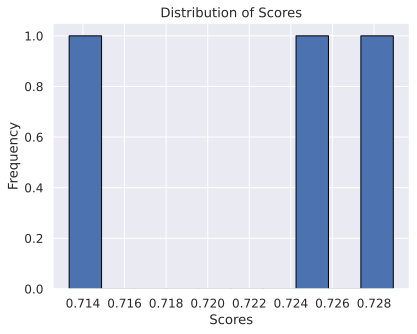

In [ ]:
# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

In [ ]:
# Showing the results of the best performing model
plot_cm_with_percentages(best_model_true_labels, best_model_predictions, mapping, name="informative_best")

NameError: ignored

In [ ]:
print(classification_report(best_model_true_labels, best_model_predictions, target_names = mapping))

                      precision    recall  f1-score   support

Counting and Results       0.78      0.78      0.78       205
   Political Rallies       0.63      0.73      0.68        78
     Positive Events       0.85      0.69      0.76       343
     Security Issues       0.68      0.74      0.71       122
       Voting Issues       0.66      0.78      0.71       228

            accuracy                           0.74       976
           macro avg       0.72      0.74      0.73       976
        weighted avg       0.75      0.74      0.74       976



In [ ]:
# Looking at the performance across language groups

In [ ]:
# What do i need to do to answert this research question conclusively?
# Load the model and make inference from it
# See how it performs also on the nigerian dataset

In [ ]:
run = 'Run3'

In [ ]:
### Reload the model and the tokenizer
xlmrmodel = XLMRobertaForSequenceClassification.from_pretrained(f'/content/drive/My Drive/thesis/models/Binary/{run}')
desc = xlmrmodel.to(device)
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/test_data.csv', encoding='utf-8')

In [ ]:
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/test_data.csv', encoding='utf-8')

In [ ]:
tokenizer = init_tokenizer()

test_sentences, test_targets = test_data.normalized_text.values, test_data.target.values
en_input_ids, en_attention_masks, en_labels = tokenize(tokenizer, 128, test_sentences, test_targets)
en_dataset = TensorDataset(en_input_ids, en_attention_masks, en_labels)
# Create dataloaders
en_dataloader = DataLoader(
        en_dataset,  # The training samples.
        sampler = SequentialSampler(en_dataset), # Select batches randomly
        batch_size = 32 # Trains with this batch size.
    )

predictions, true_labels = test_model(xlmrmodel,en_dataloader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                 precision    recall  f1-score   support

Non-Informative       0.69      0.75      0.72       976
    Informative       0.86      0.82      0.84      1861

       accuracy                           0.80      2837
      macro avg       0.77      0.78      0.78      2837
   weighted avg       0.80      0.80      0.80      2837



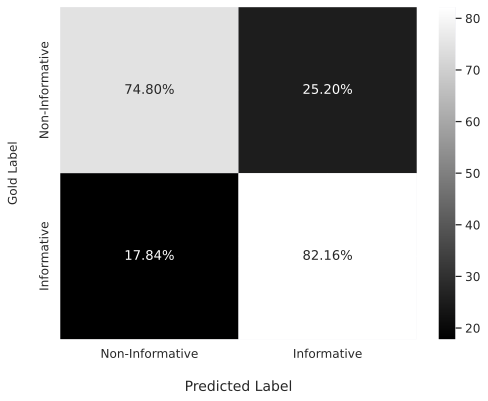

In [ ]:
print_classification_report(predictions, true_labels, target_names)

In [ ]:
train_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/train_data.csv', encoding='utf-8')
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/test_data.csv', encoding='utf-8')
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/test_data.csv', encoding='utf-8')

In [ ]:
# First classification task for informative vs non informative

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
test_data['predicted_target'] = flat_predictions

In [ ]:
test_data.shape

(2837, 19)

In [ ]:
predicted_informative = test_data[test_data['predicted_target'] == 0]

In [ ]:
train_data.to_csv('train_inf.csv', encoding='utf-8')

In [ ]:
predicted_informative.to_csv('predicted_inf.csv', encoding='utf-8')

In [ ]:
# Detect the language in test and divide it into english and non english text

In [ ]:
!pip install fasttext-langdetect

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7504 sha256=667b6f51b640cace5141a2656938a17c1ad7206795c5914c9666f959958ff642
  Stored in directory: /root/.cache/pip/wheels/e6/5b/5d/47e2fd5c2ff1028722739ce35f365e8f6eeb89ec97aa63e621
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199675 sha256=c7bdb29ebc7a2f7f061ddf305739eb5ec4624035f6859c2be3176f6d7bbe7fe9
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext-langdetect fasttext


In [ ]:
from ftlangdetect import detect

In [ ]:
import fasttext
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model = fasttext.load_model(model_path)

In [ ]:
t = model.predict("Hello, world!")

In [ ]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

In [ ]:
!pip install gcld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.8/647.8 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gcld3: filename=gcld3-3.0.13-cp310-cp310-linux_x86_64.whl size=3645069 sha256=56450d20a422b629c145bab5fa3665612d3bc924417022faeb7d1ffe1e22ca08
  Stored in directory: /root/.cache/pip/wheels/c2/11/e7/63c983a0b8506287ddd72b64db2a4d28f1e343eab85249a278
Successfully built gcld3


In [ ]:
import gcld3

In [ ]:
detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0,
                                        max_num_bytes=1000)

In [ ]:
text = "MCA tallied Wakoli 3, Priscah Chelagat 1, Jacob Kipchirchir 2, Kennedy Kemboi 1, Wilson Akubai 2, Simion Barasa Nyogesa 3."
result = detector.FindLanguage(text=text)

In [ ]:
print(result.language)

ny


In [ ]:
train_data['google_lang'] =

In [ ]:
detect_lang_fast_text(text)

'__label__cat_Latn'

In [ ]:
def google_detect(text):
  return detector.FindLanguage(text).language

In [ ]:
test_data['google_lang'] = test_data.clean_text.map(google_detect)

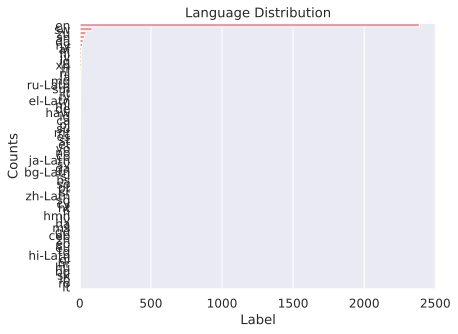

In [ ]:
grouped_counts = test_data.groupby("google_lang").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='google_lang')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

In [ ]:
english_data = test_data[test_data['google_lang'] == 'en']
non_english_data = test_data[test_data['google_lang'] == 'sw']

In [ ]:
# Assuming test_data is your DataFrame and 'google_lang' is the column you want to group by
grouped_data = test_data.groupby(['google_lang']).size().reset_index(name='count')

# Sort the DataFrame by the 'count' column in descending order
grouped_data_sorted = grouped_data.sort_values(by='count', ascending=False)

print(grouped_data_sorted)

   google_lang  count
11          en   2388
60          sw     87
66          zu     44
53          sn     32
8           da     24
..         ...    ...
1           bg      1
50          sk      1
36          lb      1
48          ro      1
37          lt      1

[67 rows x 2 columns]


In [ ]:
train_data['google_lang'] = train_data.clean_text.map(google_detect)

In [ ]:
# Assuming test_data is your DataFrame and 'google_lang' is the column you want to group by
grouped_data = train_data.groupby(['google_lang']).size().reset_index(name='count')

# Sort the DataFrame by the 'count' column in descending order
grouped_data_sorted = grouped_data.sort_values(by='count', ascending=False)

print(grouped_data_sorted)

   google_lang  count
13          en   9573
67          sw    338
74          zu    198
60          sn    139
51          ny     88
..         ...    ...
39          ky      1
68          tg      1
1           be      1
55          ru      1
27     hi-Latn      1

[75 rows x 2 columns]


In [ ]:
print(english_data.shape,non_english_data.shape)

(2388, 19) (87, 19)


In [ ]:
english_test_sentences, english_test_targets = english_data.normalized_text.values, english_data.target.values
non_english_test_sentences, non_english_test_targets = non_english_data.normalized_text.values, non_english_data.target.values

In [ ]:
def test_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
english_test_sentences, english_test_targets = english_data.normalized_text.values, english_data.target.values

In [ ]:
non_english_test_sentences, non_english_test_targets = non_english_data.normalized_text.values, non_english_data.target.values

In [ ]:
# Tokenize sentences
en_input_ids, en_attention_masks, en_labels = tokenize(tokenizer, 128, english_test_sentences, english_test_targets)
# val_input_ids, val_attention_masks, val_labels = tokenize(tokenizer, 128, val_sentences, val_targets)
nen_input_ids, nen_attention_masks, nen_labels = tokenize(tokenizer, 128, non_english_test_sentences, non_english_test_targets)

# Create datasets
en_dataset = TensorDataset(en_input_ids, en_attention_masks, en_labels)
# val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
nen_dataset = TensorDataset(nen_input_ids, nen_attention_masks, nen_labels)

batch_size = 32

# Create dataloaders
en_dataloader = DataLoader(
        en_dataset,  # The training samples.
        sampler = SequentialSampler(en_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# val_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

# For validation the order doesn't matter, so we'll just read them sequentially.
nen_dataloader = DataLoader(
            nen_dataset, # The validation samples.
            sampler = SequentialSampler(nen_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def test_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
# Test how the model performs on an english dataset
en_predictions, en_true_labels = test_model(xlmrmodel,en_dataloader)

In [ ]:
target_names = test_data['informative_label'].unique()

In [ ]:
from sklearn.metrics import f1_score
def print_classification_report(predictions, true_labels, target_names):
  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # # Calculate the MCC
  # mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  # print('Total MCC: %.3f' % mcc)
  print(f1_score(flat_true_labels,
                                  flat_predictions, average='macro' ))
  print(classification_report(flat_true_labels,
                                  flat_predictions,
                                  target_names=target_names))

  # plot_cm_with_percentages(flat_true_labels, flat_predictions, list(target_names))

In [ ]:
# print_classification_report(predictions, true_labels, target_names)

In [ ]:
 # Test Non-English Data

In [ ]:
sw_predictions, sw_true_labels = test_model(xlmrmodel,nen_dataloader)

In [ ]:
print_classification_report(sw_predictions, sw_true_labels, target_names)

0.7087517934002869
                 precision    recall  f1-score   support

    Informative       0.68      0.52      0.59        29
Non-Informative       0.78      0.88      0.83        58

       accuracy                           0.76        87
      macro avg       0.73      0.70      0.71        87
   weighted avg       0.75      0.76      0.75        87



In [ ]:
print_classification_report(en_predictions, en_true_labels, target_names)

0.7788671204475295
                 precision    recall  f1-score   support

    Informative       0.68      0.73      0.71       787
Non-Informative       0.86      0.83      0.85      1601

       accuracy                           0.80      2388
      macro avg       0.77      0.78      0.78      2388
   weighted avg       0.81      0.80      0.80      2388



In [ ]:
non_english_data.shape

(75, 19)

In [ ]:
def flatten_predictions_and_labels(predictions, true_labels):
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  return flat_predictions, flat_true_labels

In [ ]:
sw_flat_predictions, sw_flat_true_labels = flatten_predictions_and_labels(sw_predictions, sw_true_labels)

In [ ]:
en_flat_predictions, en_flat_true_labels = flatten_predictions_and_labels(en_predictions, en_true_labels)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm_with_percentages_mult(labels1, predictions1, labels2, predictions2, class_labels, name=""):
    # Compute confusion matrices for both sets of predictions
    cm1 = confusion_matrix(labels1, predictions1)
    cm2 = confusion_matrix(labels2, predictions2)

    # Calculate row-wise sums to get the total counts for each true label for both sets
    row_sums1 = cm1.sum(axis=1, keepdims=True)
    row_sums2 = cm2.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages1 = np.round((cm1 / row_sums1) * 100, decimals=2)
    cm_percentages2 = np.round((cm2 / row_sums2) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(14, 6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale=1.1)

    # Plot Confusion Matrix using Seaborn heatmap() for the first set of predictions
    ax1 = plt.subplot(1, 2, 1)
    sns.heatmap(cm_percentages1, annot=True, fmt='.2f', cmap='gist_gray', ax=ax1)
    for _, value in enumerate(ax1.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")
    ax1.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
    ax1.set_xticklabels(class_labels)
    ax1.set_ylabel("Gold Label", fontsize=12, labelpad=20)
    ax1.set_yticklabels(class_labels)
    ax1.set_title("English", fontsize=12, pad=20)

    # Plot Confusion Matrix using Seaborn heatmap() for the second set of predictions
    ax2 = plt.subplot(1, 2, 2)
    sns.heatmap(cm_percentages2, annot=True, fmt='.2f', cmap='gist_gray', ax=ax2)
    for _, value in enumerate(ax2.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")
    ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
    ax2.set_xticklabels(class_labels)
    ax2.set_ylabel("Gold Label", fontsize=12, labelpad=20)
    ax2.set_yticklabels(class_labels)
    ax2.set_title("Swahili", fontsize=12, pad=20)

    plt.tight_layout()
    plt.savefig('language_fairness.svg')
    plt.show()


In [ ]:
print(en_flat_true_labels.shape, en_flat_predictions.shape)

(2437,) (2437,)


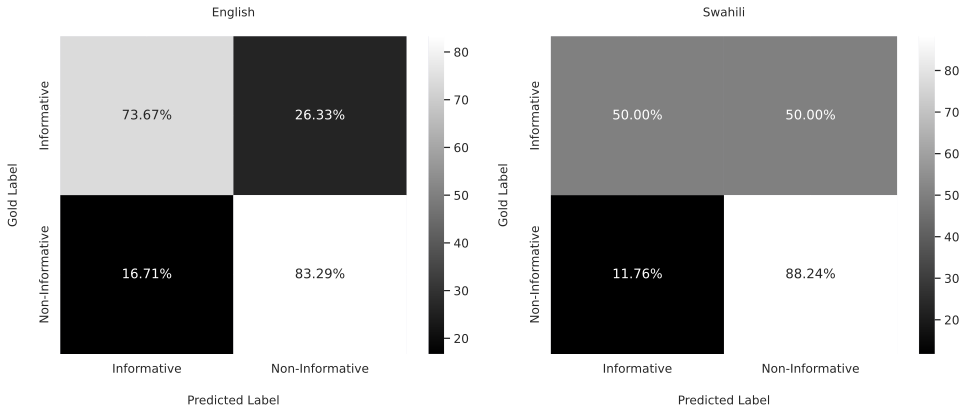

In [ ]:
plot_cm_with_percentages_mult(en_flat_true_labels, en_flat_predictions, sw_flat_true_labels, sw_flat_predictions, target_names)

In [ ]:
# Informative type classification task

In [ ]:
# Load model

In [ ]:
multi_class_run = 'Run3'

In [ ]:
### Reload the model and the tokenizer
xlmrmodel = BertConcatFeatures.from_pretrained(f'/content/drive/My Drive/thesis/models/fused/Multi-Class/{multi_class_run}')
desc = xlmrmodel.to(device)

You are using a model of type bert to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/My Drive/thesis/models/fused/Multi-Class/Run3 were not used when initializing BertConcatFeatures: ['linear_classifier.bias', 'linear_classifier.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at /content/drive/My Drive/thesis/models/fused/Multi-Class/Run3 and are newly initi

MLP Layer sizes:
 Input: 774
 Output: 5


In [ ]:
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/fused/Multi-Class/{multi_class_run}/test_data.csv', encoding='utf-8')

In [ ]:
test_data.shape

(976, 20)

In [ ]:
test_data['google_lang'] = test_data.text.map(google_detect)

In [ ]:
# test_data['tf_lang'] = test_data.normalized_text.map(google_detect)

In [ ]:
non_english_data = test_data[test_data['google_lang'] == 'sw']
english_data = test_data[test_data['google_lang'] == 'en']
print(non_english_data.shape, english_data.shape)

(33, 21) (799, 21)


In [ ]:
# non_english_data.head()

In [ ]:
numerical_feats = ['election_distance_transformed', 'hour_cos', 'hour_sin','negative','neutral','positive']

In [ ]:
# Get train sentences and targets
en_train_sentences, en_train_targets = combine_features(english_data)
nen_test_sentences, nen_test_targets = combine_features(non_english_data)

# Tokenize sentences
tokenizer = init_tokenizer()
en_input_ids, en_numerical_feats, en_attention_masks, en_labels = tokenize_with_numerical(tokenizer,
                                                                                                      en_train_sentences,
                                                                                                      en_train_targets,
                                                                                                      english_data[numerical_feats].values)
nen_input_ids, nen_numerical_feats, nen_attention_masks, nen_labels = tokenize_with_numerical(tokenizer,
                                                                                                  nen_test_sentences,
                                                                                                  nen_test_targets,
                                                                                                  non_english_data[numerical_feats].values)

# Create datasets
en_dataset = TensorDataset(en_input_ids, en_numerical_feats, en_attention_masks, en_labels)
nen_dataset = TensorDataset(nen_input_ids, nen_numerical_feats, nen_attention_masks, nen_labels)

# Create dataloaders
en_dataloader = DataLoader(
        en_dataset,  # The training samples.
        sampler = SequentialSampler(en_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )


# For validation the order doesn't matter, so we'll just read them sequentially.
nen_dataloader = DataLoader(
            nen_dataset, # The validation samples.
            sampler = SequentialSampler(nen_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

<ipython-input-133-150513d2e624>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context'] = df['context'].fillna('')


  DONE.
Dataset contains 799 samples.
  DONE.
Dataset contains 33 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning

In [ ]:
mapping = ['Counting and Results','Political Rallies','Positive Events', 'Security Issues','Voting Issues']

                      precision    recall  f1-score   support

Counting and Results       0.21      0.34      0.26       157
   Political Rallies       0.07      0.05      0.06        61
     Positive Events       0.15      0.09      0.11       294
     Security Issues       0.08      0.18      0.11        94
       Voting Issues       0.13      0.08      0.10       193

            accuracy                           0.14       799
           macro avg       0.13      0.15      0.13       799
        weighted avg       0.14      0.14      0.13       799



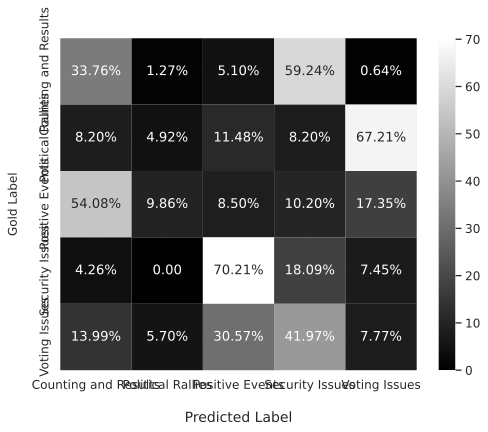

In [ ]:
predictions, true_labels = test_custom_model(xlmrmodel,en_dataloader)
print_classification_report(predictions, true_labels, mapping)

                      precision    recall  f1-score   support

Counting and Results       0.88      0.88      0.88        48
   Political Rallies       0.63      0.71      0.67        17
     Positive Events       0.85      0.69      0.76        49
     Security Issues       0.74      0.71      0.73        28
       Voting Issues       0.74      0.91      0.82        35

            accuracy                           0.79       177
           macro avg       0.77      0.78      0.77       177
        weighted avg       0.80      0.79      0.79       177



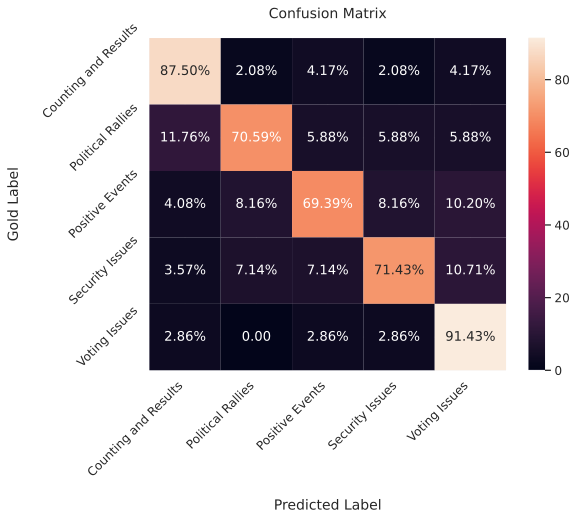

In [ ]:
predictions, true_labels = test_custom_model(xlmrmodel,nen_dataloader)
print_classification_report(predictions, true_labels, mapping)

In [ ]:
# Error analysis, misclassified posts - sample 200 and save file, perform error analysis on them

In [ ]:
# Informative Classification task error analysis

In [ ]:
### Reload the model and the tokenizer
xlmrmodel = XLMRobertaForSequenceClassification.from_pretrained(f'/content/drive/My Drive/thesis/models/Binary/{run}')
desc = xlmrmodel.to(device)
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/Binary/{run}/test_data.csv', encoding='utf-8')

In [ ]:
train_sentences, train_targets = test_data.normalized_text.values, test_data.target.values

In [ ]:
# Tokenize sentences
input_ids, attention_masks, labels = tokenize(tokenizer, 128, train_sentences, train_targets)

# Create datasets
test_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

# Create dataloaders
test_dataloader = DataLoader(
        test_dataset,  # The training samples.
        sampler = SequentialSampler(test_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

                 precision    recall  f1-score   support

    Informative       0.68      0.75      0.71      1463
Non-Informative       0.86      0.82      0.84      2792

       accuracy                           0.79      4255
      macro avg       0.77      0.78      0.78      4255
   weighted avg       0.80      0.79      0.79      4255



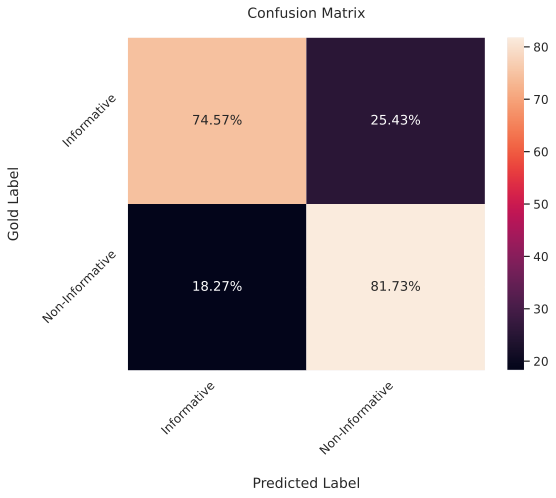

In [ ]:
predictions, true_labels = test_model(xlmrmodel,test_dataloader)
print_classification_report(predictions, true_labels, ['Informative','Non-Informative'])

In [ ]:
# Create a dataset with the misclassified

In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
test_data['predicted_target'] = flat_predictions

In [ ]:
misclassified = test_data[test_data['target'] != test_data['predicted_target']]

In [ ]:
switched_mapping = {0:'Informative', 1:'Non-Informative'}

In [ ]:
misclassified['Predicted Label'] = misclassified['predicted_target'].map(switched_mapping)

<ipython-input-421-66554f9b01dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['Predicted Label'] = misclassified['predicted_target'].map(switched_mapping)


In [ ]:
misclassified[['text','informative_label','Predicted Label']].sample(100)

,text,informative_label,Predicted Label
3913,"In the Results of IEBC,is says that more elderly registered and elderly are the highest voters of Raila",Non-Informative,Informative
3363,Our resolve to elect @Cleophasmalala and @HassanOmarH as the next Governors of Kakamega and Mombasa County respectively remains unnbowed. All sinister motives shall fail.,Non-Informative,Informative
1484,"Statement/Announcement by IEBC regarding the missing of a returning officer for Embakasi East constituency, Mr. Daniel Musyoka",Non-Informative,Informative
2297,Youth & various leaders are at the center stage to ensure we have #UchaguziWaAmani & #LetPeaceWin in the forthcoming #GE2022 through Voter information Sharing and other Peace initiatives. \n\nGroup Photo session at the ongoing Coast & Eastern Region Voter Education in Mombasa.,Non-Informative,Informative
83,"Please if you are a kenyan let us chose to have a peaceful election 'Amani ni tamu'.Am,Nancy ,Migori.",Informative,Non-Informative
...,...,...,...
3035,Ungana nami mzakendo wa kilifi tukalinde haki ya kila mmoja yakupiga kura kwa amani na bila uoga wowote\n#uchaguziwaamani,Non-Informative,Informative
1678,James Opiyo Wandati successfully defends his Ugunja parliamentary seat on an ODM ticket.,Non-Informative,Informative
2562,"""lets not bleed so that they can lead""",Informative,Non-Informative
3160,"LETS PRAY FOR OUR RAILA TO CHANGE HIS MIND AND ACCEPT UHURU TO BE THE PRESIDENT.DAUDI ARAP OMARI FROM KABARNET, BARINGO.",Non-Informative,Informative


In [ ]:
misclassified.to_csv(f"/content/drive/My Drive/thesis/results/informative_misclassified.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)

In [ ]:
# Look at the misclassified posts for the multiclassification task

In [ ]:
multi_class_run = 'Run3'
### Reload the model and the tokenizer
xlmrmodel = BertConcatFeatures.from_pretrained(f'/content/drive/My Drive/thesis/models/fused/Multi-Class/{multi_class_run}')
desc = xlmrmodel.to(device)

You are using a model of type bert to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.


MLP Layer sizes:
 Input: 774
 Output: 5


In [ ]:
test_data = pd.read_csv(f'/content/drive/My Drive/thesis/multiple_runs/fused/Multi-Class/{multi_class_run}/test_data.csv', encoding='utf-8')

In [ ]:
# Get train sentences and targets
train_sentences, train_targets = combine_features(test_data)

# Tokenize sentences
tokenizer = init_tokenizer()
input_ids, numerical_feat, attention_masks, labels = tokenize_with_numerical(tokenizer,
                                                                              train_sentences,
                                                                              train_targets,
                                                                              test_data[numerical_feats].values)

# Create datasets
test_dataset = TensorDataset(input_ids, numerical_feat, attention_masks, labels)

# Create dataloaders
test_dataloader = DataLoader(
        test_dataset,  # The training samples.
        sampler = SequentialSampler(test_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

  DONE.
Dataset contains 976 samples.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                      precision    recall  f1-score   support

Counting and Results       0.78      0.78      0.78       205
   Political Rallies       0.63      0.73      0.68        78
     Positive Events       0.85      0.69      0.76       343
     Security Issues       0.68      0.74      0.71       122
       Voting Issues       0.66      0.78      0.71       228

            accuracy                           0.74       976
           macro avg       0.72      0.74      0.73       976
        weighted avg       0.75      0.74      0.74       976



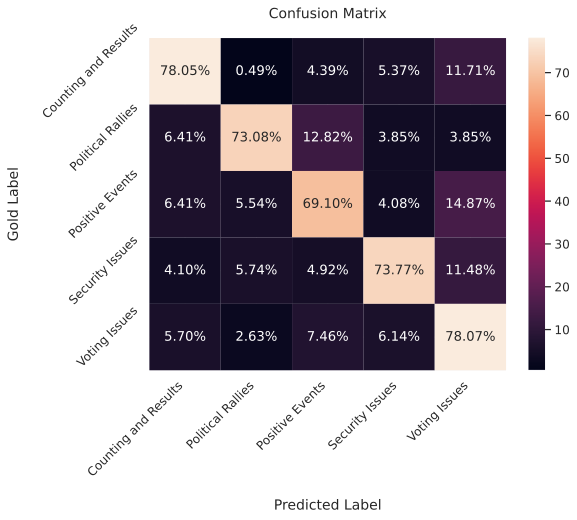

In [ ]:
predictions, true_labels = test_custom_model(xlmrmodel,test_dataloader)
print_classification_report(predictions, true_labels, mapping)

In [ ]:
# A peek into misclassified

In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
test_data['predicted_target'] = flat_predictions

In [ ]:
misclassified_inf = test_data[test_data['target'] != test_data['predicted_target']]

In [ ]:
misclassified_inf.shape

(254, 21)

In [ ]:
mapping

['Counting and Results',
 'Political Rallies',
 'Positive Events',
 'Security Issues',
 'Voting Issues']

In [ ]:
def create_idx_mapping(labels):
  idx_map = {}
  for idx, label in enumerate(labels):
    idx_map[idx] = label
  return idx_map

In [ ]:
idx_map = create_idx_mapping(mapping)
idx_map

{0: 'Counting and Results',
 1: 'Political Rallies',
 2: 'Positive Events',
 3: 'Security Issues',
 4: 'Voting Issues'}

In [ ]:
misclassified_inf['Predicted Label'] = misclassified_inf['predicted_target'].map(idx_map)

<ipython-input-458-a13a04a35361>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_inf['Predicted Label'] = misclassified_inf['predicted_target'].map(idx_map)


In [ ]:
misclassified_inf[['text','merged_label','Predicted Label']].sample(20)

,text,merged_label,Predicted Label
260,I live in naivasha while my vote card indicates that I'm a voter in kangundo,Positive Events,Voting Issues
123,NEWS UPDATE: DP Ruto arrives at Bomas for the announcement of Presidential elections,Positive Events,Political Rallies
925,People from different wards bribed to register in our ward in order to make a certain aspirant pass,Voting Issues,Positive Events
222,"Several tens of people already in the queue 7hrs before polls open at Moi Avenue Primary, Starehe constituency… https://t.co/c96FE75o56",Voting Issues,Political Rallies
235,"Go to the iebc portal,the results are there for you to see.stop consoling yourself with tv results",Voting Issues,Counting and Results
963,At emung'weso polling center voting is on.iebc official locked out from a small room they were to use but officers took control and the environment is fairly good.voter turnout is 0.9(5/599voters registered),Positive Events,Voting Issues
150,A post shows a crowd of people running away after police officers fire tear gas towards crowd,Security Issues,Counting and Results
897,Presiding officer counted votes for each candidate in an open manner and filled out the results on tallying sheet( Form 33)#Suna-East,Positive Events,Counting and Results
751,Thanks to advanced technology people who are visually impaired can also enjoy using this platforms. Hata IEBC ingekubali some of us could have voted online now that hakuna ballot papers in brail.,Voting Issues,Positive Events
77,Ballot boxes are visible to all present in the polling station#KURIA WEST#MOHETO PRI.,Positive Events,Voting Issues


In [ ]:
misclassified_inf.to_csv(f"/content/drive/My Drive/thesis/results/multiclass_misclassified.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)